In [1]:
import os

import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import sonnet as snt

from graph_nets import utils_tf
from graph_nets import utils_np
from graph_nets import graphs

from root_gnn.src.generative import rnn_mlp_gan as toGan
from root_gnn.utils_plot import add_mean_std

In [2]:
batch_size = 1024
n_batches = 4 # 14
noise_dim = 32
disc_num_iters = 4
# output_dir = '/global/homes/x/xju/work/Herwig/PrimaryOnly/mlpGAN/v1'
output_dir = '/global/homes/x/xju/work/Herwig/PrimaryOnly/rnnGAN/v4'
test_data_name = '/global/homes/x/xju/work/Herwig/PrimaryOnly_1M/inputs/test/primary_11.tfrec'

In [3]:
gan = toGan.GAN(max_nodes=2)

In [4]:
optimizer = toGan.GANOptimizer(
    gan,
    batch_size=batch_size,
    noise_dim=noise_dim,
    num_epcohs=1,
    with_disc_reg=True
)

In [5]:
ckpt_dir = os.path.join(output_dir, "checkpoints")
checkpoint = tf.train.Checkpoint(
    optimizer=optimizer,
    gan=gan)

In [6]:
ckpt_manager = tf.train.CheckpointManager(checkpoint, directory=ckpt_dir,
                            max_to_keep=5, keep_checkpoint_every_n_hours=8)

In [7]:
_ = checkpoint.restore(ckpt_manager.latest_checkpoint)

In [8]:
from root_gnn.trainer import read_dataset
from root_gnn.trainer import loop_dataset

INFO:tensorflow:TF Version:2.4.1


In [9]:
def visiual(predicts, truths):
#     predicts = predicts * node_abs_max[1:]
#     truths = truths * node_abs_max[1:]
    
    hist_config = {
        "alpha": 0.5,
        "lw": 2,
        'histtype': 'step',
    }
    nbins = 40
    max_x = 1.2
    config_4vector = [
        dict([("bins",nbins), ("range",(-max_x, max_x))]),
        dict([("bins",nbins), ("range",(-max_x, max_x))]),
        dict([("bins",nbins), ("range",(-max_x, max_x))]),
        dict([("bins",nbins), ("range",(-max_x, max_x))])
    ]
    
    xr = 10
    nbinsd = 40
    config_4vectord = [
        dict([("bins",nbinsd), ("range",(-xr, xr))]),
        dict([("bins",nbinsd), ("range",(-xr, xr))]),
        dict([("bins",nbinsd), ("range",(-xr, xr))]),
        dict([("bins",nbinsd), ("range",(-2, 2))]),
    ]

    xlabels_diff = ['($p_\mathrm{predict}^{x}-p_\mathrm{true}^{x}$)/$p_\mathrm{true}^{x}$ [GeV]',
               '($p_\mathrm{predict}^{y}-p_\mathrm{true}^{y}$)/$p_\mathrm{true}^{y}$ [GeV]',
               '($p_\mathrm{predict}^{z}-p_\mathrm{true}^{z}$)/$p_\mathrm{true}^{z}$ [GeV]',
               '($E_\mathrm{predict}-E_\mathrm{true}$/$E_\mathrm{true}$ [GeV]']
    xp = [1, 1, 1, 0.5]
    yp = np.array([60]*3 + [30])
    dy = np.array([10]*4)
    
    def plot_4vector(offset):
        _, axs = plt.subplots(2,2, figsize=(10,10), constrained_layout=True)
        axs = axs.flatten()
        xlabels = ['E [GeV]', 'px [GeV]', 'py [GeV]', 'pz [GeV]']
        for ix in range(4):
            idx = ix
            axs[ix].hist(predicts[:, offset, idx], **hist_config, **config_4vector[ix], label="prediction")
            axs[ix].hist(truths[:, offset, idx], **hist_config, **config_4vector[ix], label="truth")
            axs[ix].set_xlabel(xlabels[ix])
        axs[ix].legend(loc='upper right')
            
#         _, axs = plt.subplots(2,2, figsize=(10,10), constrained_layout=True)
#         axs = axs.flatten()
#         offset = 0
#         for ix in range(4):
#             idx = ix
#             diff = (predicts[:, offset, idx]-truths[:, offset, idx])/truths[:, offset, idx]
#             max_diff = np.max(diff)
#             diff = diff[np.abs(diff) < xr]
# #             print(idx, np.std(diff), max_diff, diff.shape[0])
#             axs[ix].hist(diff, **hist_config, **config_4vectord[ix], label="prediction")
#             axs[ix].set_xlabel(xlabels_diff[ix])
#             add_mean_std(diff, xp[ix], yp[ix], axs[ix], dy=dy[ix])

    for idx in range(2):
        plot_4vector(idx)

In [10]:
node_abs_max = np.array([
    [49.1, 47.7, 46.0, 47.0],
    [46.2, 40.5, 41.0, 39.5],
    [42.8, 36.4, 37.0, 35.5]
], dtype=np.float32)

node_mean = np.array([
    [14.13, 0.05, -0.10, -0.04], 
    [7.73, 0.02, -0.04, -0.08],
    [6.41, 0.04, -0.06, 0.04]
], dtype=np.float32)

node_scales = np.array([
    [13.29, 10.54, 10.57, 12.20], 
    [8.62, 6.29, 6.35, 7.29],
    [6.87, 5.12, 5.13, 5.90]
], dtype=np.float32)

def normalize(inputs, targets):
    input_nodes = (inputs.nodes - node_mean[0])/node_scales[0]
    target_nodes = np.reshape(targets.nodes, [batch_size, -1, 4])
    target_nodes = np.reshape(target_nodes/node_abs_max, [batch_size, -1])
    return input_nodes, target_nodes

In [11]:
def check_file(filename, ngen=1000):
    dataset, n_graphs = read_dataset(test_data_name)
    print("total {} graphs iterated with batch size of {} and {} batches".format(n_graphs, batch_size, n_batches))
    print('averaging {} geneveted events for each input'.format(ngen))
    test_data = loop_dataset(dataset, batch_size)
    predict_4vec = []
    truth_4vec = []
    for ib in range(n_batches):
        inputs, targets = next(test_data)
        input_nodes, target_nodes = normalize(inputs, targets)
        
        gen_evts = []
        for igen in range(ngen):
            noises = tf.random.normal([batch_size, noise_dim], dtype=tf.float32)
            inputs = tf.concat([input_nodes, noises], axis=-1)
            gen_graph = gan.generate(inputs)
            gen_evts.append(gen_graph)
        
        gen_evts = tf.reduce_mean(tf.stack(gen_evts), axis=0)
        
        predict_4vec.append(tf.reshape(gen_evts, [batch_size, -1, 4]))
        truth_4vec.append(tf.reshape(target_nodes, [batch_size, -1, 4])[:, 1:, :])
        
    predict_4vec = tf.concat(predict_4vec, axis=0)
    truth_4vec = tf.concat(truth_4vec, axis=0)
    visiual(predict_4vec.numpy(), truth_4vec.numpy())

total 5000 graphs iterated with batch size of 1024 and 4 batches
averaging 1 geneveted events for each input


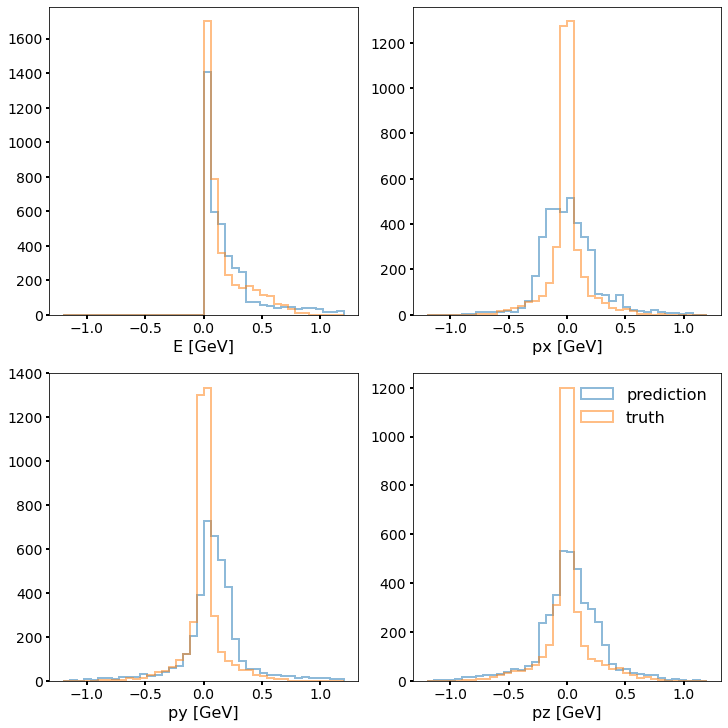

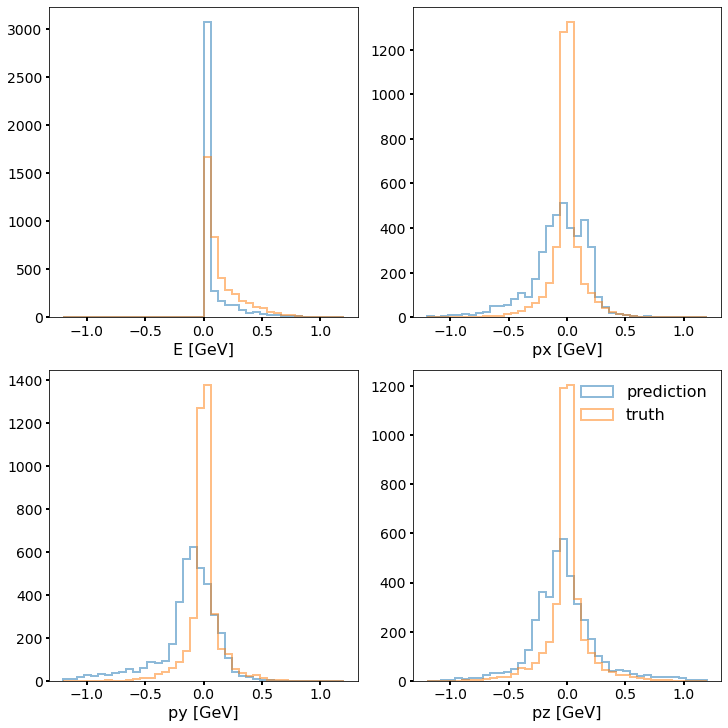

In [12]:
check_file(test_data_name, ngen=1)

In [13]:
x = np.arange(-2, 2.1, step=0.1)
y = x **2 
y2 = -x**2

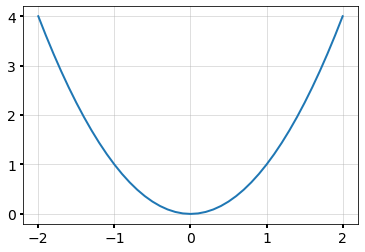

In [14]:
plt.plot(x, y)
# plt.plot(x, y2)
plt.grid()